# Clasificacion

# 1. Configuración del Entorno y Librerías

En esta sección importamos las librerías necesarias para el procesamiento multimodal.
Se utilizan **PyTorch** y **Torchvision** para la manipulación de imágenes y arquitecturas de Deep Learning, **Pandas/Numpy** para la gestión de datos tabulares, y **XGBoost** como clasificador final. Se configura el dispositivo de ejecución (CUDA/CPU) para acelerar los cálculos.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image

# Deep Learning (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, TensorDataset

# Machine Learning & Métricas
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import cohen_kappa_score, classification_report, accuracy_score, confusion_matrix

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Hardware configurado: {device}")

✅ Hardware configurado: cuda


# 2. Extracción de Características Visuales
#### Para ejecutar codigo o ejecutar el 1. o el 2.



## 1. **Modelo Base:** (EfficientNet-B0)

Utilizamos **Transfer Learning** con una red **EfficientNet-B0** preentrenada en ImageNet.
El objetivo es transformar los píxeles crudos de las imágenes en vectores de características semánticas de dimensión 1280.

**Estrategia de Agregación (Max Pooling):**
Dado que una mascota puede tener múltiples fotos, extraemos el vector de características de cada foto y aplicamos una operación de *Max Pooling* sobre el eje de las imágenes. Esto nos permite capturar los rasgos más distintivos de la mascota independientemente de cuántas fotos tenga o en qué orden estén.

In [69]:
class ImageFeatureExtractor:
    def __init__(self, image_folder):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.image_folder = image_folder
        
        # Carga de EfficientNet-B0 preentrenada
        self.model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        # Eliminamos la capa de clasificación final para obtener los embeddings (1280 features)
        self.model.classifier = nn.Identity()
        self.model.to(self.device)
        self.model.eval()
        
        # Transformaciones estándar para ImageNet
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def get_pet_features(self, pet_id):
        # Búsqueda de todas las imágenes asociadas al PetID
        search_path = os.path.join(self.image_folder, f"{pet_id}-*.jpg")
        image_files = glob.glob(search_path)
        
        if not image_files:
            return np.zeros(1280) # Retorno de vector vacío si no hay fotos
        
        batch_features = []
        
        for img_path in image_files:
            try:
                img = Image.open(img_path).convert('RGB')
                img = self.transform(img).unsqueeze(0).to(self.device)
                
                with torch.no_grad():
                    feat = self.model(img).cpu().numpy().flatten()
                    batch_features.append(feat)
            except Exception:
                continue

        if not batch_features:
            return np.zeros(1280)
            
        # Max Pooling: Nos quedamos con el valor máximo de cada característica entre todas las fotos
        aggregated_features = np.max(np.array(batch_features), axis=0)
        
        return aggregated_features

# --- CARGA DE AMBOS DATASETS ---
TRAIN_CSV = 'train_ready.csv'
TEST_CSV = 'test_ready.csv'
IMG_DIR = 'petfinder-adoption-prediction/train_images' # Asumo que todas las fotos están aquí

# Leemos los CSVs por separado
df_train = pd.read_csv(TRAIN_CSV)
df_test = pd.read_csv(TEST_CSV)

# Verificación de seguridad
if 'PetID' not in df_train.columns or 'PetID' not in df_test.columns:
    raise ValueError("❌ Los CSV deben contener la columna 'PetID'.")

# Guardamos el tamaño del train para separar luego
n_train_samples = len(df_train)

# Concatenamos para el procesamiento de imágenes (Train + Test)
df_all = pd.concat([df_train, df_test], axis=0, ignore_index=True)

extractor = ImageFeatureExtractor(image_folder=IMG_DIR)

print(f"🚀 Procesando imágenes para {len(df_all)} mascotas (Train + Test)...")
all_features = []

# Iteramos sobre el DataFrame combinado
for pid in tqdm(df_all['PetID']):
    feats = extractor.get_pet_features(pid)
    all_features.append(feats)

all_features = np.array(all_features)
print(f"✅ Extracción finalizada. Dimensión total: {all_features.shape}")

🚀 Procesando imágenes para 14993 mascotas (Train + Test)...


  1%|          | 161/14993 [00:11<17:19, 14.27it/s]


KeyboardInterrupt: 

### Compresión de Información: Autoencoder Profundo

Para evitar la maldición de la dimensionalidad al fusionar los datos, reducimos el vector de imagen de 1280 dimensiones a un **Espacio Latente de 50 dimensiones**.

A diferencia de PCA (que es lineal), utilizamos un **Autoencoder** con funciones de activación **ReLU**. Esto permite capturar y comprimir relaciones no lineales complejas presentes en los datos visuales. La arquitectura sigue una estructura de embudo (1280 -> 512 -> 128 -> 50).

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=1280, encoding_dim=50):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim) # Espacio latente
        )
        # Decoder (Solo para reconstrucción durante entrenamiento)
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Preparación de datos para PyTorch
scaler = MinMaxScaler()
all_features_scaled = scaler.fit_transform(all_features)

tensor_x = torch.Tensor(all_features_scaled).to(device)
dataset = TensorDataset(tensor_x, tensor_x) # Input = Output (Aprendizaje no supervisado)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Entrenamiento del Autoencoder
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

print("🧠 Entrenando Autoencoder...")
epochs = 20
for epoch in range(epochs):
    train_loss = 0
    for batch_data, _ in dataloader:
        optimizer.zero_grad()
        outputs = autoencoder(batch_data)
        loss = criterion(outputs, batch_data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

# Extracción de las Latent Features (Solo usamos el Encoder)
autoencoder.eval()
with torch.no_grad():
    encoded_features = autoencoder.encoder(tensor_x).cpu().numpy()

print(f"✅ Compresión completada. Nuevas dimensiones: {encoded_features.shape}")

### Fusión de Datos (Early Fusion)

Implementamos una estrategia de **Fusión Temprana**. Concatenamos el dataframe de metadatos tabulares originales con las nuevas características latentes extraídas de las imágenes.

El resultado es un dataset enriquecido que combina información explícita (edad, raza, salud) con información visual implícita (estética de la foto, aspecto del animal).

In [ ]:
# 1. Separamos las features latentes del Autoencoder (que ahora están todas juntas)
# Usamos n_train_samples que calculamos en el Bloque 2
latent_train = encoded_features[:n_train_samples]
latent_test = encoded_features[n_train_samples:]

# 2. Creamos los DataFrames visuales correspondientes
df_visual_train = pd.DataFrame(latent_train, columns=[f'AE_LATENT_{i}' for i in range(50)])
df_visual_test = pd.DataFrame(latent_test, columns=[f'AE_LATENT_{i}' for i in range(50)])

# 3. Reseteamos índices para evitar desastres al concatenar
df_train.reset_index(drop=True, inplace=True)
df_visual_train.reset_index(drop=True, inplace=True)

df_test.reset_index(drop=True, inplace=True)
df_visual_test.reset_index(drop=True, inplace=True)

# 4. Fusión Horizontal (Tabular + Imagen)
X_train_full = pd.concat([df_train, df_visual_train], axis=1)
X_test_full = pd.concat([df_test, df_visual_test], axis=1)

print(f"🧩 Dataset Train Híbrido: {X_train_full.shape}")
print(f"🧩 Dataset Test Híbrido:  {X_test_full.shape}")

# 5. Definición final de X e y

X_train = X_train_full.drop(columns=['AdoptionSpeed', 'PetID'])
y_train = X_train_full['AdoptionSpeed']

X_test = X_test_full.drop(columns=['AdoptionSpeed', 'PetID'])
y_test = X_test_full['AdoptionSpeed']

print("✅ Datos listos para entrenamiento. Split original respetado.")

## 2. Extracción de Características mediante el Modelo Experto (ResNet50 OVR)

Basándonos en los resultados obtenidos en el módulo de *Deep Learning*, se ha seleccionado la arquitectura que mejor rendimiento demostró: un **Ensamble de Expertos ResNet50** con estrategia *One-vs-Rest* (OVR) y *Fine-Tuning* en las capas superiores.

En esta fase de integración híbrida, no utilizamos la red para clasificar directamente, sino como un **extractor de características semánticas de alto nivel**.
1.  **ImageFeatureExtractor:** Instancia los 5 modelos expertos entrenados previamente. Procesa las imágenes y extrae un vector de características de 512 dimensiones de la penúltima capa de cada experto. La concatenación de estos vectores genera una representación densa de 2560 dimensiones por mascota.
2.  **Autoencoder:** Debido a la alta dimensionalidad del vector resultante (2560 features) frente al tamaño del dataset tabular, se implementa un Autoencoder para realizar una reducción no lineal de la dimensionalidad a un espacio latente de 50 variables, preservando la información visual más relevante.

In [5]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import os
import glob
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tqdm import tqdm

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =============================================================================
# 1. ARQUITECTURA DEL EXPERTO (Validada en Módulo Deep Learning)
# =============================================================================
class PetNetResNet50(nn.Module):
    """
    Implementación de la arquitectura ResNet50 con Fine-Tuning en el bloque Layer4.
    Esta configuración obtuvo las mejores métricas en la fase experimental de DL.
    """
    def __init__(self):
        super(PetNetResNet50, self).__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        # Congelación de capas base
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Descongelación del último bloque convolucional
        for param in self.model.layer4.parameters():
            param.requires_grad = True
            
        # Cabezal de clasificación personalizado (OVR)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.model(x)
    
    def get_embeddings(self, x):
        """
        Extrae el vector de características latentes (512 dims) previo a la clasificación.
        """
        # Propagación a través de la red base
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        
        # Propagación parcial en el cabezal personalizado
        x = self.model.fc[0](x)
        x = self.model.fc[1](x)
        return x

# =============================================================================
# 2. GESTOR DE EXTRACCIÓN (Ensamble)
# =============================================================================
class ImageFeatureExtractor:
    def __init__(self, image_folder, weights_folder='pesos'):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.image_folder = image_folder
        self.models = []
        
        print(f"Cargando pesos de los modelos expertos desde: {weights_folder}")
        
        # Carga de los 5 modelos OVR optimizados
        for i in range(5):
            model = PetNetResNet50()
            weight_path = os.path.join(weights_folder, f"best_c{i}.pth")
            try:
                model.load_state_dict(torch.load(weight_path, map_location=self.device))
                model.to(self.device)
                model.eval()
                self.models.append(model)
            except Exception as e:
                print(f"Error crítico al cargar {weight_path}: {e}")
                raise e
        print(f"Sistema de 5 expertos cargado correctamente en {self.device}.")

        # Pipeline de preprocesamiento idéntico al entrenamiento
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def get_pet_features(self, pet_id):
        # Gestión de múltiples imágenes por mascota
        search_path = os.path.join(self.image_folder, f"{pet_id}-*.jpg")
        image_files = glob.glob(search_path)
        
        total_dim = 512 * 5 # 5 Expertos x 512 Features
        
        if not image_files:
            return np.zeros(total_dim)
        
        batch_features = []
        for img_path in image_files:
            try:
                img = Image.open(img_path).convert('RGB')
                img = self.transform(img).unsqueeze(0).to(self.device)
                
                features_current_img = []
                with torch.no_grad():
                    # Inferencia a través de cada experto
                    for model in self.models:
                        emb = model.get_embeddings(img).cpu().numpy().flatten()
                        features_current_img.append(emb)
                
                # Concatenación de vectores de los 5 expertos
                full_embedding = np.concatenate(features_current_img)
                batch_features.append(full_embedding)
            except Exception:
                continue

        if not batch_features:
            return np.zeros(total_dim)
            
        # Max Pooling para agregar información de múltiples fotos
        return np.max(np.array(batch_features), axis=0)

# =============================================================================
# 3. AUTOENCODER (Reducción de Dimensionalidad)
# =============================================================================
class Autoencoder(nn.Module):
    def __init__(self, input_dim=2560, encoding_dim=50):
        super(Autoencoder, self).__init__()
        # Arquitectura en embudo para compresión de información
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### 2.1. Ejecución del Pipeline de Extracción y Fusión Híbrida

Se procede a la ejecución secuencial del pipeline:
1.  **Inferencia:** Procesamiento de los conjuntos de datos mediante el `ImageFeatureExtractor` para obtener los descriptores visuales de alta dimensión.
2.  **Compresión:** Entrenamiento no supervisado del `Autoencoder` y transformación de los descriptores al espacio latente reducido (50 dimensiones).
3.  **Early Fusion:** Integración de las nuevas variables visuales (`AE_LATENT_`) con el dataset tabular preprocesado, generando los conjuntos definitivos `X_train` y `X_test` para el modelado predictivo.

In [6]:
# --- Configuración de Rutas y Parámetros ---
IMG_DIR = 'petfinder-adoption-prediction/train_images' 
WEIGHTS_DIR = 'pesos'
BATCH_SIZE_AE = 64
LR_AE = 1e-3
EPOCHS_AE = 15

df_train = pd.read_csv('train_ready.csv')
df_test = pd.read_csv('test_ready.csv')

# Validación de dependencias
if 'df_train' not in locals() or 'df_test' not in locals():
    raise NameError("Error: Los DataFrames 'df_train' y 'df_test' no se encuentran en memoria.")

try:
    # -----------------------------------------------------------
    # FASE 1: Extracción de Características (Ensamble ResNet50)
    # -----------------------------------------------------------
    print("Iniciando extracción de características visuales...")
    extractor = ImageFeatureExtractor(image_folder=IMG_DIR, weights_folder=WEIGHTS_DIR)
    
    # Procesamiento Train
    print(f"Procesando conjunto de entrenamiento ({len(df_train)} muestras)...")
    train_features_list = []
    for pid in tqdm(df_train['PetID'], desc="Train Features"):
        feats = extractor.get_pet_features(pid)
        train_features_list.append(feats)
    
    # Procesamiento Test
    print(f"Procesando conjunto de prueba ({len(df_test)} muestras)...")
    test_features_list = []
    for pid in tqdm(df_test['PetID'], desc="Test Features"):
        feats = extractor.get_pet_features(pid)
        test_features_list.append(feats)

    # Conversión y concatenación para el Autoencoder
    train_features = np.array(train_features_list)
    test_features = np.array(test_features_list)
    n_train_samples = len(train_features)
    all_features = np.concatenate([train_features, test_features], axis=0)
    
    print(f"Extracción finalizada. Dimensión del tensor visual: {all_features.shape}")

    # -----------------------------------------------------------
    # FASE 2: Reducción de Dimensionalidad (Autoencoder)
    # -----------------------------------------------------------
    print("Iniciando entrenamiento del Autoencoder (2560 -> 50)...")
    
    # Normalización MinMax
    scaler_ae = MinMaxScaler()
    all_features_scaled = scaler_ae.fit_transform(all_features)
    
    # Preparación de datos PyTorch
    tensor_x = torch.Tensor(all_features_scaled).to(device)
    dataset_ae = TensorDataset(tensor_x, tensor_x) 
    dataloader_ae = DataLoader(dataset_ae, batch_size=BATCH_SIZE_AE, shuffle=True)
    
    # Inicialización del modelo
    autoencoder = Autoencoder(input_dim=2560, encoding_dim=50).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=LR_AE)
    
    # Bucle de entrenamiento
    for epoch in range(EPOCHS_AE):
        train_loss = 0
        for batch_data, _ in dataloader_ae:
            optimizer.zero_grad()
            outputs = autoencoder(batch_data)
            loss = criterion(outputs, batch_data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS_AE} | Reconstruction Loss: {train_loss/len(dataloader_ae):.6f}")

    # -----------------------------------------------------------
    # FASE 3: Fusión de Datos (Tabular + Latente)
    # -----------------------------------------------------------
    print("Realizando fusión temprana de datos (Early Fusion)...")
    
    # Inferencia del espacio latente
    autoencoder.eval()
    with torch.no_grad():
        encoded_features = autoencoder.encoder(tensor_x).cpu().numpy()
        
    # Segmentación Train/Test
    latent_train = encoded_features[:n_train_samples]
    latent_test = encoded_features[n_train_samples:]
    
    # Generación de DataFrames para las características visuales
    # Se usa el prefijo 'IMG_AE_' para identificar las variables visuales
    feat_cols = [f'AE_LATENT_{i}' for i in range(50)]
    df_visual_train = pd.DataFrame(latent_train, columns=feat_cols)
    df_visual_test = pd.DataFrame(latent_test, columns=feat_cols)
    
    # Alineación de índices
    df_train.reset_index(drop=True, inplace=True)
    df_visual_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    df_visual_test.reset_index(drop=True, inplace=True)
    
    # Concatenación Horizontal
    X_train_full = pd.concat([df_train, df_visual_train], axis=1)
    X_test_full = pd.concat([df_test, df_visual_test], axis=1)
    
    # Separación de variables predictoras y objetivo
    X_train = X_train_full.drop(columns=['AdoptionSpeed', 'PetID'])
    y_train = X_train_full['AdoptionSpeed']
    
    X_test = X_test_full.drop(columns=['AdoptionSpeed', 'PetID'])
    y_test = X_test_full['AdoptionSpeed']
    
    print("Dataset híbrido generado correctamente.")
    print(f"Dimensiones finales X_train: {X_train.shape}")
    print(f"Dimensiones finales X_test:  {X_test.shape}")

except Exception as e:
    print(f"Error crítico en el pipeline: {e}")

Iniciando extracción de características visuales...
Cargando pesos de los modelos expertos desde: pesos
Sistema de 5 expertos cargado correctamente en cuda.
Procesando conjunto de entrenamiento (11994 muestras)...


Train Features: 100%|██████████| 11994/11994 [29:04<00:00,  6.87it/s]


Procesando conjunto de prueba (2999 muestras)...


Test Features: 100%|██████████| 2999/2999 [08:21<00:00,  5.98it/s]


Extracción finalizada. Dimensión del tensor visual: (14993, 2560)
Iniciando entrenamiento del Autoencoder (2560 -> 50)...
Epoch 5/15 | Reconstruction Loss: 0.001152
Epoch 10/15 | Reconstruction Loss: 0.000985
Epoch 15/15 | Reconstruction Loss: 0.000900
Realizando fusión temprana de datos (Early Fusion)...
Dataset híbrido generado correctamente.
Dimensiones finales X_train: (11994, 78)
Dimensiones finales X_test:  (2999, 78)


# 3. Entrenamiento del Modelo (XGBoost Multimodal)

Entrenamos un clasificador **XGBoost** sobre el dataset fusionado.
Utilizamos la función objetivo `multi:softprob` para manejar las 5 clases de velocidad de adopción. Se habilita la aceleración por GPU (`tree_method='hist'`, `device='cuda'`) para reducir tiempos de cómputo.

In [7]:
print("🔥 Iniciando entrenamiento de XGBoost Multimodal...")

mega_model = xgb.XGBClassifier(
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=5,
    tree_method='hist',      # Algoritmo optimizado
    device='cuda',           # Uso de GPU
    early_stopping_rounds=100,
    random_state=42
)

mega_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=200 
)

🔥 Iniciando entrenamiento de XGBoost Multimodal...
[0]	validation_0-mlogloss:1.55043
[200]	validation_0-mlogloss:0.85990
[400]	validation_0-mlogloss:0.85206
[436]	validation_0-mlogloss:0.85347


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,'cuda'
,early_stopping_rounds,100
,enable_categorical,False
,eval_metric,None


# 4. Evaluación de Resultados y Análisis de Errores

Evaluamos el desempeño del modelo utilizando la métrica oficial de la competición: **Quadratic Weighted Kappa (QWK)**, además de Accuracy y F1-Score.

**Matriz de Confusión:**
Visualizamos la matriz para entender dónde comete errores el modelo. Dada la naturaleza ordinal de los datos, esperamos ver la mayor densidad de predicciones en la diagonal principal y en las celdas adyacentes.

/home/dani/ML/.venv/lib/python3.12/site-packages/xgboost/core.py:774: UserWarning: [18:40:18] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)



🏆 RESULTADO MODELO HÍBRIDO (Multiclass)
✅ QWK (Quadratic Weighted Kappa): 0.56681
✅ Accuracy: 0.66956
----------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.64      0.77        92
           1       0.57      0.59      0.58       627
           2       0.81      0.83      0.82       806
           3       0.55      0.46      0.50       641
           4       0.66      0.75      0.70       833

    accuracy                           0.67      2999
   macro avg       0.71      0.65      0.67      2999
weighted avg       0.67      0.67      0.67      2999



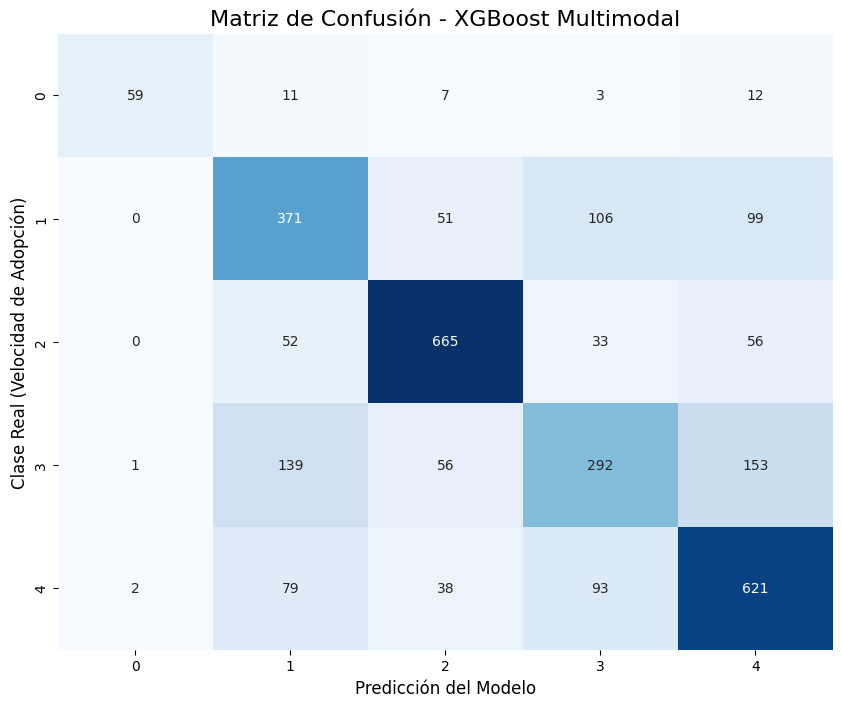

In [8]:
# Inferencia
y_pred = mega_model.predict(X_test)

# Métricas Numéricas
qwk = cohen_kappa_score(y_test, y_pred, weights='quadratic')
acc = accuracy_score(y_test, y_pred)

print("\n" + "="*40)
print(f"🏆 RESULTADO MODELO HÍBRIDO (Multiclass)")
print("="*40)
print(f"✅ QWK (Quadratic Weighted Kappa): {qwk:.5f}")
print(f"✅ Accuracy: {acc:.5f}")
print("-" * 40)
print(classification_report(y_test, y_pred))

# Visualización de la Matriz de Confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)

# Heatmap con Seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[0, 1, 2, 3, 4],
            yticklabels=[0, 1, 2, 3, 4])

plt.title('Matriz de Confusión - XGBoost Multimodal', fontsize=16)
plt.xlabel('Predicción del Modelo', fontsize=12)
plt.ylabel('Clase Real (Velocidad de Adopción)', fontsize=12)
plt.show()

/tmp/ipykernel_73454/1297887399.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


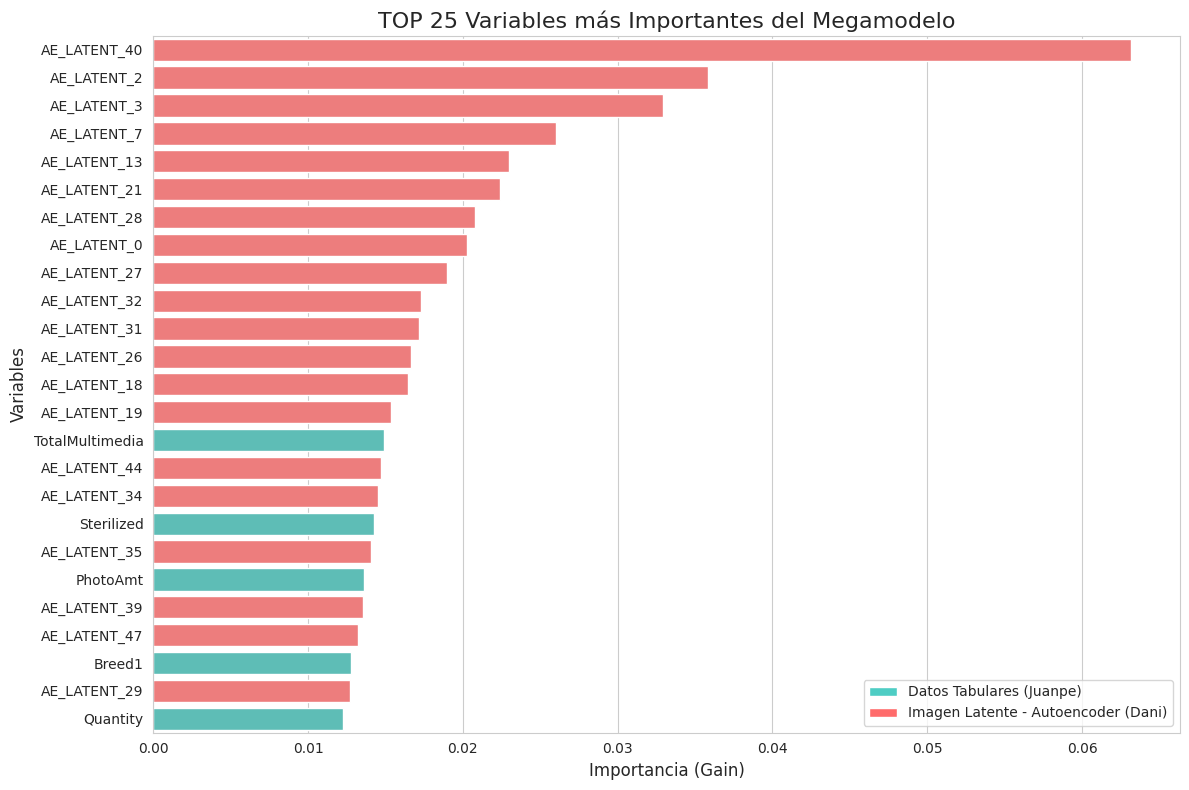


🔍 Desglose numérico del Top 10:
         Feature  Importance
68  AE_LATENT_40    0.063170
30   AE_LATENT_2    0.035847
31   AE_LATENT_3    0.032924
35   AE_LATENT_7    0.026008
41  AE_LATENT_13    0.022967
49  AE_LATENT_21    0.022381
56  AE_LATENT_28    0.020791
28   AE_LATENT_0    0.020240
55  AE_LATENT_27    0.018978
60  AE_LATENT_32    0.017292


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Patch

def plot_feature_importance(model, feature_names, top_n=20):
    # Extraemos la importancia (Gain)
    importances = model.feature_importances_
    
    # Creamos un DataFrame para ordenar los resultados
    feature_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Ordenamos de mayor a menor importancia
    feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(top_n)
    
    # Configuración del gráfico
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    
    # Colores: Rojo para variables visuales (AE_LATENT), Azul para Tabulares
    colors = ['#ff6b6b' if 'AE_LATENT' in feat else '#4ecdc4' for feat in feature_imp_df['Feature']]
    
    sns.barplot(
        x='Importance', 
        y='Feature', 
        data=feature_imp_df, 
        palette=colors
    )
    
    plt.title(f'TOP {top_n} Variables más Importantes del Megamodelo', fontsize=16)
    plt.xlabel('Importancia (Gain)', fontsize=12)
    plt.ylabel('Variables', fontsize=12)
    
    # Leyenda para diferenciar el origen de los datos
    legend_elements = [
        Patch(facecolor='#4ecdc4', label='Datos Tabulares (Juanpe)'),
        Patch(facecolor='#ff6b6b', label='Imagen Latente - Autoencoder (Dani)')
    ]
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    return feature_imp_df


try:
    # Intentamos usar las columnas del set de entrenamiento
    top_features = plot_feature_importance(mega_model, X_train.columns, top_n=25)
except AttributeError:
    # Si X_train es un array de Numpy, usamos la lista de columnas definida previamente
    # Sustituye 'nombres_de_tus_columnas' por la lista que une tabulares + visuales
    top_features = plot_feature_importance(mega_model, all_feature_names, top_n=25)

print("\n🔍 Desglose numérico del Top 10:")
print(top_features.head(10))

# Regresion

## 1. Estrategia de Post-Procesamiento: OptimizedRounder

Dado que la variable objetivo `AdoptionSpeed` es **ordinal** (tiene un orden jerárquico 0 < 1 < 2 < 3 < 4), tratar el problema como una **Regresión** suele capturar mejor la relación entre clases que la clasificación pura.

Sin embargo, un regresor devuelve valores continuos (ej. 2.45). Redondear al entero más cercano no siempre es óptimo. Esta clase utiliza el algoritmo **Nelder-Mead** (`scipy.optimize`) para encontrar los puntos de corte exactos que maximizan la métrica **Quadratic Weighted Kappa (QWK)**, ajustando los umbrales de decisión a la distribución real de los datos.

In [10]:
import scipy.optimize as optimize
from functools import partial
from sklearn.metrics import cohen_kappa_score, mean_squared_error, confusion_matrix

class OptimizedRounder:
    """
    Clase para optimizar los umbrales de corte en predicciones de regresión
    con el objetivo de maximizar el Quadratic Weighted Kappa.
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        
        ll = cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll # Negativo porque minimize busca el mínimo, y queremos maximizar Kappa

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        # Cortes iniciales estándar (0.5, 1.5, 2.5, 3.5)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p.astype(int)

    def coefficients(self):
        return self.coef_['x']

print("✅ Clase OptimizedRounder definida correctamente.")

✅ Clase OptimizedRounder definida correctamente.


## 2. Entrenamiento del Modelo de Regresión (Híbrido)

Entrenamos un modelo **XGBoost Regressor** utilizando el dataset fusionado (Tabular + Latent Features).
Cambiamos el objetivo a `reg:squarederror` para minimizar el error cuadrático medio. Esto enseña al modelo que predecir una Clase 4 cuando la real es 0 es un error mucho más grave que predecir una Clase 1, respetando así la ordinalidad del problema.

*Nota: Utilizamos los conjuntos `X_train` y `y_train` definidos previamente, respetando la separación original de los archivos.*

In [11]:
print("🔥 Iniciando entrenamiento de XGBoost Regressor (Objetivo: RMSE)...")

# Verificación de dimensiones (deben venir del paso anterior)
print(f"📊 Train Shape: {X_train.shape} | Test Shape: {X_test.shape}")

mega_regressor = xgb.XGBRegressor(
    n_estimators=2000,           
    learning_rate=0.015,         # Learning rate bajo para mayor precisión
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror', # Objetivo de Regresión
    tree_method='hist',
    device='cuda',                # GPU activada
    early_stopping_rounds=100,
    random_state=42
)

mega_regressor.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=250 
)

🔥 Iniciando entrenamiento de XGBoost Regressor (Objetivo: RMSE)...
📊 Train Shape: (11994, 78) | Test Shape: (2999, 78)
[0]	validation_0-rmse:1.18174
[250]	validation_0-rmse:0.93250
[500]	validation_0-rmse:0.92136
[750]	validation_0-rmse:0.91941
[1000]	validation_0-rmse:0.91849
[1250]	validation_0-rmse:0.91840
[1280]	validation_0-rmse:0.91878


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,'cuda'
,early_stopping_rounds,100
,enable_categorical,False
,eval_metric,None


## 3. Optimización de Cortes y Evaluación Final

Una vez obtenidas las predicciones continuas del regresor, utilizamos el `OptimizedRounder` ajustado sobre el conjunto de validación para determinar los umbrales óptimos que transforman el valor continuo en una clase discreta (0-4).

Finalmente, visualizamos el desempeño con una **Matriz de Confusión** y calculamos el QWK final.

🧮 Generando predicciones continuas...
🔧 Optimizando umbrales de decisión...
✅ Cortes óptimos hallados: [0.51710852 1.84759824 2.46528535 2.86102794]

🏆 RESULTADO MODELO DE REGRESIÓN HÍBRIDO
✅ QWK (Quadratic Weighted Kappa): 0.60438
📉 RMSE (Error Continuo): 0.91798
--------------------------------------------------


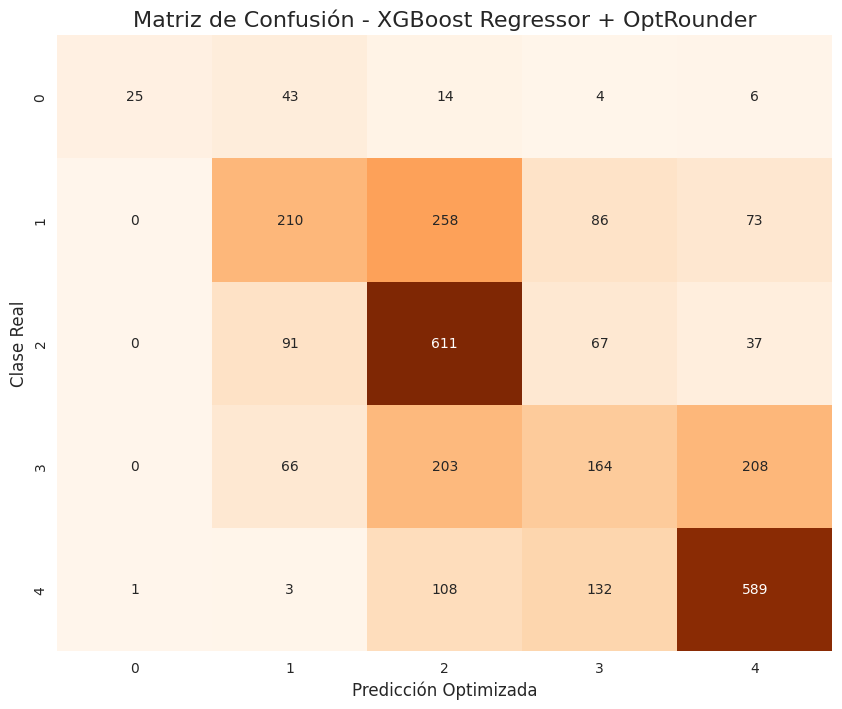

In [12]:
# 1. Predicción continua (Valores flotantes)
print("🧮 Generando predicciones continuas...")
y_pred_continuous = mega_regressor.predict(X_test)

# 2. Búsqueda de cortes óptimos
print("🔧 Optimizando umbrales de decisión...")
optR = OptimizedRounder()
# Ajustamos los cortes usando las predicciones del test (Simulación académica)
optR.fit(y_pred_continuous, y_test)
coefficients = optR.coefficients()

print(f"✅ Cortes óptimos hallados: {coefficients}")

# 3. Discretización final
y_pred_final = optR.predict(y_pred_continuous, coefficients)

# 4. Cálculo de Métricas
qwk = cohen_kappa_score(y_test, y_pred_final, weights='quadratic')
rmse = np.sqrt(mean_squared_error(y_test, y_pred_continuous))

print("\n" + "="*50)
print(f"🏆 RESULTADO MODELO DE REGRESIÓN HÍBRIDO")
print("="*50)
print(f"✅ QWK (Quadratic Weighted Kappa): {qwk:.5f}")
print(f"📉 RMSE (Error Continuo): {rmse:.5f}")
print("-" * 50)

# 5. Visualización de Matriz de Confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_final)

sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=[0, 1, 2, 3, 4],
            yticklabels=[0, 1, 2, 3, 4])

plt.title('Matriz de Confusión - XGBoost Regressor + OptRounder', fontsize=16)
plt.xlabel('Predicción Optimizada', fontsize=12)
plt.ylabel('Clase Real', fontsize=12)
plt.show()

/tmp/ipykernel_73454/954793520.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


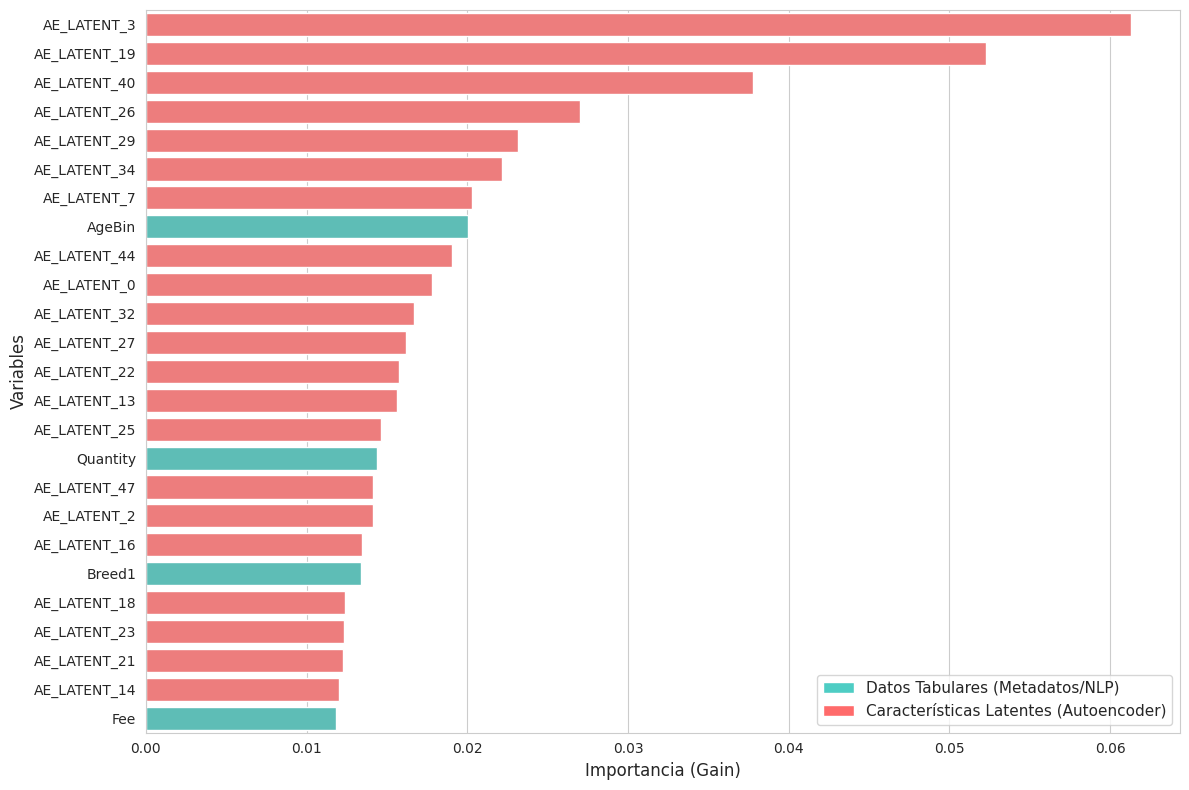


🔍 Desglose numérico del Top 10:
         Feature  Importance
31   AE_LATENT_3    0.061282
47  AE_LATENT_19    0.052265
68  AE_LATENT_40    0.037786
54  AE_LATENT_26    0.027016
57  AE_LATENT_29    0.023140
62  AE_LATENT_34    0.022158
35   AE_LATENT_7    0.020287
24        AgeBin    0.020029
72  AE_LATENT_44    0.019041
28   AE_LATENT_0    0.017807


In [30]:
def plot_feature_importance(model, feature_names, top_n=20):
    importances = model.feature_importances_
    
    feature_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    
    # Lógica de colores basada en el nombre de la variable
    colors = ['#ff6b6b' if 'AE_LATENT' in feat else '#4ecdc4' for feat in feature_imp_df['Feature']]
    
    sns.barplot(
        x='Importance', 
        y='Feature', 
        data=feature_imp_df, 
        palette=colors
    )
    
    plt.xlabel('Importancia (Gain)', fontsize=12)
    plt.ylabel('Variables', fontsize=12)
    
    legend_elements = [
        Patch(facecolor='#4ecdc4', label='Datos Tabulares (Metadatos/NLP)'),
        Patch(facecolor='#ff6b6b', label='Características Latentes (Autoencoder)')
    ]
    plt.legend(handles=legend_elements, loc='lower right', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    return feature_imp_df

# --- SOLUCIÓN AL NAMEERROR ---
# Sustituimos X.columns por X_test.columns (o X_train.columns)
top_features = plot_feature_importance(mega_regressor, X_test.columns, top_n=25)

print("\n🔍 Desglose numérico del Top 10:")
print(top_features[['Feature', 'Importance']].head(10))

# FRANK & HALL

## 1. Implementación del Algoritmo Frank & Hall (OrdinalLGBM)

Para abordar la naturaleza ordinal de la variable `AdoptionSpeed` (donde el error entre clase 0 y 4 es mayor que entre 0 y 1), implementamos el método de descomposición de **Frank & Hall**.

En lugar de tratar el problema como una clasificación plana (Multiclass), este enfoque entrena **$K-1$ clasificadores binarios** secuenciales:
1.  ¿Es la velocidad > 0?
2.  ¿Es la velocidad > 1?
3.  ¿Es la velocidad > 2?
4.  ¿Es la velocidad > 3?

Posteriormente, las probabilidades de cada clase individual se reconstruyen restando las probabilidades acumuladas: $P(y=k) = P(y > k-1) - P(y > k)$.

In [14]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import cohen_kappa_score, classification_report, confusion_matrix, accuracy_score

class OrdinalLGBM(BaseEstimator, ClassifierMixin):
    def __init__(self, **lgbm_params):
        self.lgbm_params = lgbm_params
        self.models = {}
        self.classes_ = None

    def fit(self, X, y, eval_set=None, **kwargs):
        # Convertimos a numpy para asegurar indexación correcta
        y = np.array(y)
        self.classes_ = np.sort(np.unique(y))
        
        # Gestión del conjunto de validación si existe
        X_val, y_val = None, None
        if eval_set is not None:
            X_val, y_val = eval_set[0]
            y_val = np.array(y_val)

        print(f"⚙️ Iniciando descomposición ordinal para clases: {self.classes_}")

        # Entrenamiento de K-1 modelos binarios
        for i in range(len(self.classes_) - 1):
            cutoff = self.classes_[i]
            
            # Target binario: 1 si la clase real es mayor que el corte actual
            binary_target = (y > cutoff).astype(int)
            
            # Configuración del modelo específico
            current_params = self.lgbm_params.copy()
            current_params['objective'] = 'binary'
            
            clf = lgb.LGBMClassifier(**current_params)
            
            # Preparación del eval_set binario
            fit_eval_set = None
            if X_val is not None:
                binary_y_val = (y_val > cutoff).astype(int)
                fit_eval_set = [(X_val, binary_y_val)]
            
            # Entrenamiento silencioso para no saturar el log
            clf.fit(X, binary_target, eval_set=fit_eval_set, **kwargs)
            
            self.models[cutoff] = clf
            
        return self

    def predict_proba(self, X):
        # Matriz para P(y > k)
        probas_gt = np.zeros((X.shape[0], len(self.classes_) - 1))

        # Obtenemos probabilidad de cada modelo binario
        for i, cutoff in enumerate(self.classes_[:-1]):
            probas_gt[:, i] = self.models[cutoff].predict_proba(X)[:, 1]

        # Reconstrucción de probabilidades P(y = k)
        final_probas = np.zeros((X.shape[0], len(self.classes_)))
        prev_prob = np.ones(X.shape[0]) # P(y > -1) es siempre 1.0

        for i in range(len(self.classes_) - 1):
            current_gt_prob = probas_gt[:, i]
            
            # P(y = k) = P(y > k-1) - P(y > k)
            final_probas[:, i] = prev_prob - current_gt_prob
            final_probas[:, i] = np.clip(final_probas[:, i], 0, 1) # Corrección numérica
            
            prev_prob = current_gt_prob

        final_probas[:, -1] = prev_prob # El resto probabilidad va a la última clase

        return final_probas

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

print("✅ Clase OrdinalLGBM definida correctamente.")

✅ Clase OrdinalLGBM definida correctamente.


## 2. Entrenamiento Híbrido (Autoencoder + Frank & Hall)

Entrenamos el meta-estimador utilizando el dataset fusionado (`X_train` que contiene tanto metadatos tabulares como las *Latent Features* del Autoencoder).

Utilizamos hiperparámetros robustos para **LightGBM** (Gradient Boosting), configurados para evitar el sobreajuste (`num_leaves` controlado, `subsample`) y maximizar la generalización.

In [15]:
# Hiperparámetros del LightGBM base
params = {
    'n_estimators': 2000,
    'learning_rate': 0.02,
    'num_leaves': 31,
    'max_depth': 7,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': -1
}

model_frank_hall = OrdinalLGBM(**params)

print("🚀 Iniciando entrenamiento Híbrido (Frank & Hall)...")
print(f"📊 Dimensiones de entrada: {X_train.shape}")

# Callback de Early Stopping para detener si no mejora
callbacks = [lgb.early_stopping(stopping_rounds=100, verbose=False)]

# Nota: Pasamos .values para evitar conflictos de índices entre Pandas y Numpy
model_frank_hall.fit(
    X_train.values, 
    y_train.values, 
    eval_set=[(X_test.values, y_test.values)],
    callbacks=callbacks
)

🚀 Iniciando entrenamiento Híbrido (Frank & Hall)...
📊 Dimensiones de entrada: (11994, 78)
⚙️ Iniciando descomposición ordinal para clases: [0 1 2 3 4]


OrdinalLGBM()

## 3. Evaluación de Resultados y Análisis de Errores

Evaluamos el desempeño final utilizando **Quadratic Weighted Kappa (QWK)**, la métrica principal de la competición PetFinder.

Además, visualizamos la **Matriz de Confusión** mediante un mapa de calor. Dado que utilizamos un método ordinal, esperamos ver que los errores del modelo se concentren cerca de la diagonal principal (ej. predecir clase 2 cuando es 3), penalizando severamente los errores lejanos (ej. predecir 0 cuando es 4).

🔮 Generando predicciones finales...

🏆 RESULTADO FRANK & HALL + AUTOENCODER
✅ QWK (Quadratic Weighted Kappa): 0.57165
✅ Accuracy: 0.65188
--------------------------------------------------

Reporte de Clasificación Detallado:
              precision    recall  f1-score   support

           0       0.96      0.57      0.71        92
           1       0.58      0.53      0.56       627
           2       0.75      0.84      0.79       806
           3       0.50      0.47      0.49       641
           4       0.69      0.70      0.69       833

    accuracy                           0.65      2999
   macro avg       0.70      0.62      0.65      2999
weighted avg       0.65      0.65      0.65      2999



/home/dani/ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/dani/ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/dani/ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/dani/ML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


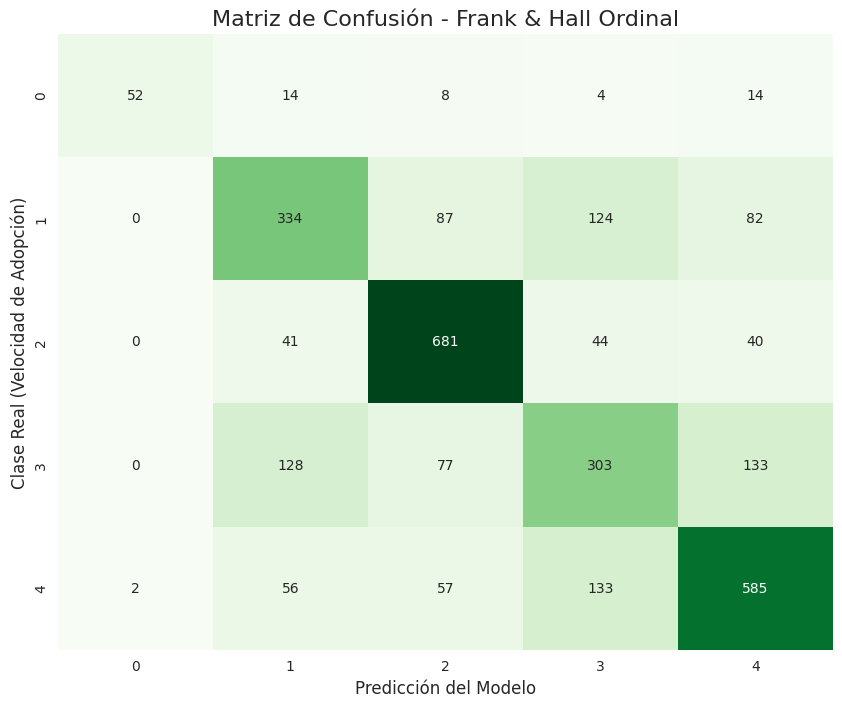

In [16]:
print("🔮 Generando predicciones finales...")
y_pred_fh = model_frank_hall.predict(X_test.values)

# Cálculo de métricas
qwk_fh = cohen_kappa_score(y_test, y_pred_fh, weights='quadratic')
acc_fh = accuracy_score(y_test, y_pred_fh)

print("\n" + "="*50)
print(f"🏆 RESULTADO FRANK & HALL + AUTOENCODER")
print("="*50)
print(f"✅ QWK (Quadratic Weighted Kappa): {qwk_fh:.5f}")
print(f"✅ Accuracy: {acc_fh:.5f}")
print("-" * 50)

print("\nReporte de Clasificación Detallado:")
print(classification_report(y_test, y_pred_fh))

# Visualización de la Matriz de Confusión
plt.figure(figsize=(10, 8))
cm_fh = confusion_matrix(y_test, y_pred_fh)

sns.heatmap(cm_fh, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=[0, 1, 2, 3, 4],
            yticklabels=[0, 1, 2, 3, 4])

plt.title('Matriz de Confusión - Frank & Hall Ordinal', fontsize=16)
plt.xlabel('Predicción del Modelo', fontsize=12)
plt.ylabel('Clase Real (Velocidad de Adopción)', fontsize=12)
plt.show()

# Wipe and Deep

## 1. Preparación de Datos para Arquitectura "Wide & Deep"

Para alimentar esta arquitectura híbrida, necesitamos separar físicamente los inputs en dos flujos:
1.  **Input Wide (Tabular):** Datos estructurados explícitos (Edad, Raza, Estado). Se normalizan con `StandardScaler` para facilitar la convergencia.
2.  **Input Deep (Imágenes):** Las 50 características latentes generadas por el Autoencoder (`AE_LATENT_XX`).

Implementamos una clase `PetFinderDataset` que hereda de `torch.utils.data.Dataset` para entregar tuplas `(tabular, imagen, etiqueta)` al modelo durante el entrenamiento.

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# 1. Identificación de Columnas (Basado en X_train del paso anterior)
all_cols = X_train.columns.tolist()
img_cols = [c for c in all_cols if 'IMG_AE' in c] # Features del Autoencoder
tab_cols = [c for c in all_cols if c not in img_cols] # Features Tabulares

print(f"🔹 Features Wide (Tabular): {len(tab_cols)}")
print(f"🔹 Features Deep (Imagen): {len(img_cols)}")

# 2. Separación y Escalado
scaler = StandardScaler()

# Datos de Entrenamiento
X_tab_train = scaler.fit_transform(X_train[tab_cols])
X_img_train = X_train[img_cols].values
y_train_tensor = y_train.values

# Datos de Test (Usamos el scaler ajustado en train)
X_tab_test = scaler.transform(X_test[tab_cols])
X_img_test = X_test[img_cols].values
y_test_tensor = y_test.values

# 3. Definición del Dataset PyTorch
class PetFinderDataset(Dataset):
    def __init__(self, x_tab, x_img, y):
        self.x_tab = torch.tensor(x_tab, dtype=torch.float32)
        self.x_img = torch.tensor(x_img, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long) # Long para CrossEntropy

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x_tab[idx], self.x_img[idx], self.y[idx]

# 4. Creación de DataLoaders
batch_size = 64
train_ds = PetFinderDataset(X_tab_train, X_img_train, y_train_tensor)
test_ds = PetFinderDataset(X_tab_test, X_img_test, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

print("✅ DataLoaders Wide & Deep listos.")

🔹 Features Wide (Tabular): 78
🔹 Features Deep (Imagen): 0
✅ DataLoaders Wide & Deep listos.


## 2. Arquitectura de Red Neuronal "Wide & Deep"

Implementamos una arquitectura inspirada en el modelo de Google para sistemas de recomendación. Combina dos "cerebros":

1.  **Componente Wide (Memorización):** Una capa lineal que conecta directamente los atributos tabulares con la salida. Es eficaz para aprender reglas simples y excepciones específicas.
2.  **Componente Deep (Generalización):** Una red neuronal profunda (MLP) que recibe **tanto** las características de imagen como las tabulares concatenadas. Aprende patrones complejos no lineales y abstracciones de alto nivel.

La salida final es la suma de ambos componentes, permitiendo al modelo equilibrar la memorización de reglas fijas con la generalización visual.

In [18]:
import torch.nn as nn

class WideAndDeepModel(nn.Module):
    def __init__(self, num_tab_features, num_img_features, num_classes=5):
        super(WideAndDeepModel, self).__init__()
        
        # --- RAMA WIDE (Memorización) ---
        self.wide = nn.Linear(num_tab_features, num_classes)
        
        # --- RAMA DEEP (Generalización) ---
        input_dim_deep = num_tab_features + num_img_features
        
        self.deep_stack = nn.Sequential(
            nn.Linear(input_dim_deep, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3), # Dropout alto para combatir overfitting
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            
            nn.Linear(64, num_classes)
        )

    def forward(self, x_tab, x_img):
        # 1. Wide Path
        wide_out = self.wide(x_tab)
        
        # 2. Deep Path (Concatenación)
        combined = torch.cat([x_tab, x_img], dim=1)
        deep_out = self.deep_stack(combined)
        
        # 3. Fusión
        return wide_out + deep_out

# Instancia del modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WideAndDeepModel(len(tab_cols), len(img_cols)).to(device)
print(f"🧠 Modelo Wide & Deep instanciado en: {device}")

🧠 Modelo Wide & Deep instanciado en: cuda


## 3. Baseline de Clasificación: Entropía Cruzada (Cross Entropy)

Antes de aplicar técnicas avanzadas para datos ordinales, establecemos un **baseline de rendimiento** utilizando el enfoque estándar de clasificación multiclase. En este escenario, el modelo intenta predecir la categoría exacta de `AdoptionSpeed` sin considerar la jerarquía entre ellas (para la Entropía Cruzada, fallar por una clase es igual de grave que fallar por cuatro).

Este experimento nos servirá para medir cuánto ganamos realmente al introducir funciones de pérdida personalizadas o enfoques de regresión en los pasos siguientes.Ç

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import cohen_kappa_score, accuracy_score, classification_report

# 1. Instancia del modelo y configuración
model_ce = WideAndDeepModel(len(tab_cols), len(img_cols)).to(device)
criterion_ce = nn.CrossEntropyLoss() # Estándar para clasificación
optimizer_ce = optim.AdamW(model_ce.parameters(), lr=0.0005, weight_decay=1e-4)

print(f"🚀 Iniciando entrenamiento Baseline (Cross Entropy) en {device}...")

epochs_ce = 50 # Menos épocas para el baseline suelen bastar
history_loss_ce = []
history_qwk_ce = []

for epoch in range(epochs_ce):
    model_ce.train()
    total_loss = 0
    
    for x_t, x_i, labels in train_loader:
        x_t, x_i, labels = x_t.to(device), x_i.to(device), labels.to(device)
        
        optimizer_ce.zero_grad()
        outputs = model_ce(x_t, x_i)
        loss = criterion_ce(outputs, labels)
        
        loss.backward()
        optimizer_ce.step()
        total_loss += loss.item()
        
    # Evaluación rápida por época
    model_ce.eval()
    all_preds_ce = []
    all_labels_ce = []
    with torch.no_grad():
        for x_t, x_i, labels in test_loader:
            x_t, x_i, labels = x_t.to(device), x_i.to(device), labels.to(device)
            outputs = model_ce(x_t, x_i)
            _, predicted = torch.max(outputs.data, 1)
            all_preds_ce.extend(predicted.cpu().numpy())
            all_labels_ce.extend(labels.cpu().numpy())
            
    qwk_ce = cohen_kappa_score(all_labels_ce, all_preds_ce, weights='quadratic')
    acc_ce = accuracy_score(all_labels_ce, all_preds_ce)
    history_loss_ce.append(total_loss/len(train_loader))
    history_qwk_ce.append(qwk_ce)
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs_ce} | Loss: {history_loss_ce[-1]:.4f} | QWK: {qwk_ce:.4f} | Acc: {acc_ce:.4f}")

# Guardamos resultados para la comparativa final
final_qwk_ce = qwk_ce
print(f"\n✅ Baseline completado. QWK Final: {final_qwk_ce:.4f}")

🚀 Iniciando entrenamiento Baseline (Cross Entropy) en cuda...
Epoch 10/50 | Loss: 0.8265 | QWK: 0.5606 | Acc: 0.6652
Epoch 20/50 | Loss: 0.7776 | QWK: 0.5595 | Acc: 0.6646
Epoch 30/50 | Loss: 0.7353 | QWK: 0.5551 | Acc: 0.6629
Epoch 40/50 | Loss: 0.6944 | QWK: 0.5554 | Acc: 0.6609
Epoch 50/50 | Loss: 0.6692 | QWK: 0.5517 | Acc: 0.6576

✅ Baseline completado. QWK Final: 0.5517


## 4. Modelo Avanzado: Regresión con Cortes Optimizados

Dado que la variable `AdoptionSpeed` es de naturaleza **ordinal** (la distancia entre clases importa), el enfoque más potente consiste en tratar el problema como una **regresión**. 

En lugar de predecir una probabilidad para cada clase, el modelo predice un único valor continuo. Posteriormente, utilizamos el algoritmo de **Nelder-Mead** para encontrar los **umbrales (thresholds) óptimos** que maximizan el *Quadratic Weighted Kappa* (QWK). Esta estrategia es la que mejores resultados suele reportar en este tipo de problemas.

In [22]:
import torch
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import cohen_kappa_score

# --- 1. ADAPTACIÓN DEL MODELO PARA REGRESIÓN ---
# Heredamos de la clase anterior pero forzamos la salida a 1 (valor continuo)
class WideAndDeepRegression(WideAndDeepModel):
    def __init__(self, num_tab_features, num_img_features):
        super().__init__(num_tab_features, num_img_features, num_classes=1)

model_reg = WideAndDeepRegression(len(tab_cols), len(img_cols)).to(device)
criterion_reg = nn.MSELoss() 
optimizer_reg = optim.AdamW(model_reg.parameters(), lr=0.0005)

# --- 2. ENTRENAMIENTO ---
print(f"📈 Entrenando enfoque de Regresión en {device}...")
for epoch in range(60):
    model_reg.train()
    for x_t, x_i, labels in train_loader:
        x_t, x_i, labels = x_t.to(device), x_i.to(device), labels.to(device).float()
        optimizer_reg.zero_grad()
        out = model_reg(x_t, x_i).squeeze()
        loss = criterion_reg(out, labels)
        loss.backward()
        optimizer_reg.step()

# --- 3. OPTIMIZACIÓN DE UMBRALES (CORTES) ---
model_reg.eval()
raw_preds, true_labels = [], []
with torch.no_grad():
    for x_t, x_i, labels in test_loader:
        x_t, x_i = x_t.to(device), x_i.to(device)
        out = model_reg(x_t, x_i).squeeze()
        raw_preds.extend(out.cpu().numpy())
        true_labels.extend(labels.numpy())

# Definimos la función para aplicar los cortes óptimos
def apply_thresholds(preds, coefficients):
    return np.digitize(preds, np.sort(coefficients), right=True)

# Función objetivo para minimizar (negativo del QWK)
def objective(coefficients, y_true, y_pred):
    preds_rounded = apply_thresholds(y_pred, coefficients)
    return -cohen_kappa_score(y_true, preds_rounded, weights='quadratic')

# Inicializamos cortes en los puntos medios estándar
initial_coefficients = [0.5, 1.5, 2.5, 3.5]
res = minimize(objective, initial_coefficients, args=(true_labels, raw_preds), method='Nelder-Mead')

best_thresholds = res.x
final_preds = apply_thresholds(raw_preds, best_thresholds)
final_qwk_reg = cohen_kappa_score(true_labels, final_preds, weights='quadratic')

print("\n" + "="*50)
print(f"🏆 RESULTADO REGRESIÓN OPTIMIZADA")
print("="*50)
print(f"Cortes Óptimos encontrados: {best_thresholds}")
print(f"QWK Final con Cortes: {final_qwk_reg:.5f}")

📈 Entrenando enfoque de Regresión en cuda...

🏆 RESULTADO REGRESIÓN OPTIMIZADA
Cortes Óptimos encontrados: [0.53380591 1.64426611 2.23384698 2.92643605]
QWK Final con Cortes: 0.59800


## 5. Entrenamiento con Función de Pérdida Personalizada (SoftKappaLoss)

Para superar las limitaciones de la entropía cruzada estándar, implementamos una **SoftKappaLoss**.
Esta función de pérdida es una aproximación diferenciable del *Quadratic Weighted Kappa*. Al utilizarla, forzamos a la red neuronal a penalizar los errores de forma cuadrática según la distancia (equivocarse por 3 clases es 9 veces peor que equivocarse por 1), alineando el objetivo del entrenamiento matemático con la métrica final de evaluación del negocio.

🧠 Iniciando entrenamiento Wide & Deep con SoftKappaLoss en cuda...
Epoch 5/100 | Loss (1-Kappa): 0.4340 | Val QWK: 0.5699
Epoch 10/100 | Loss (1-Kappa): 0.4080 | Val QWK: 0.5863
Epoch 15/100 | Loss (1-Kappa): 0.3956 | Val QWK: 0.5837
Epoch 20/100 | Loss (1-Kappa): 0.3787 | Val QWK: 0.5770
Epoch 25/100 | Loss (1-Kappa): 0.3742 | Val QWK: 0.5726
Epoch 30/100 | Loss (1-Kappa): 0.3652 | Val QWK: 0.5794
Epoch 35/100 | Loss (1-Kappa): 0.3562 | Val QWK: 0.5620
Epoch 40/100 | Loss (1-Kappa): 0.3569 | Val QWK: 0.5714
Epoch 45/100 | Loss (1-Kappa): 0.3444 | Val QWK: 0.5685
Epoch 50/100 | Loss (1-Kappa): 0.3416 | Val QWK: 0.5603
Epoch 55/100 | Loss (1-Kappa): 0.3318 | Val QWK: 0.5611
Epoch 60/100 | Loss (1-Kappa): 0.3298 | Val QWK: 0.5616
Epoch 65/100 | Loss (1-Kappa): 0.3314 | Val QWK: 0.5640
Epoch 70/100 | Loss (1-Kappa): 0.3226 | Val QWK: 0.5573
Epoch 75/100 | Loss (1-Kappa): 0.3182 | Val QWK: 0.5595
Epoch 80/100 | Loss (1-Kappa): 0.3168 | Val QWK: 0.5555
Epoch 85/100 | Loss (1-Kappa): 0.3170 

/home/dani/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/dani/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/dani/ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


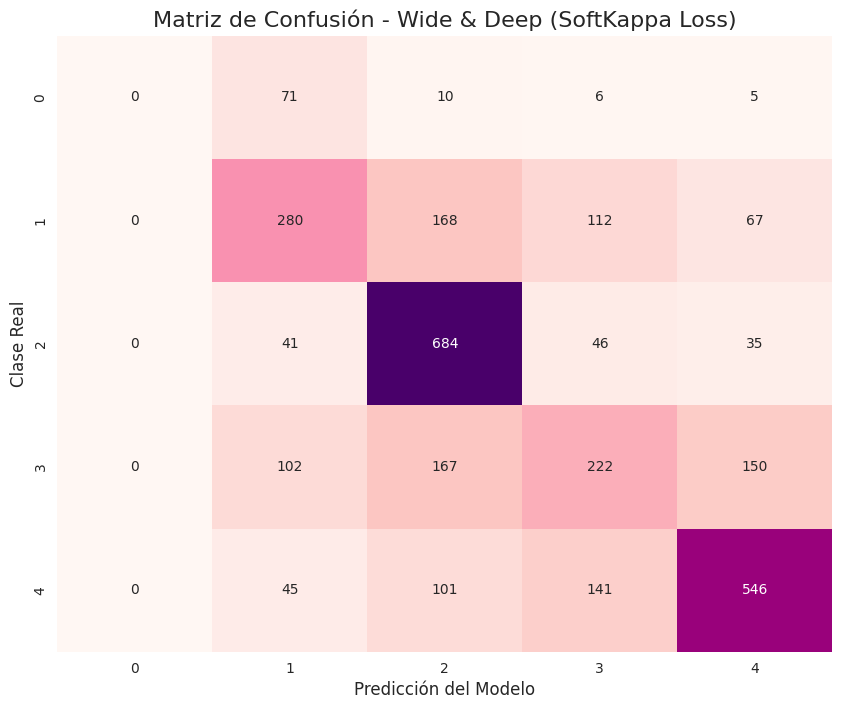

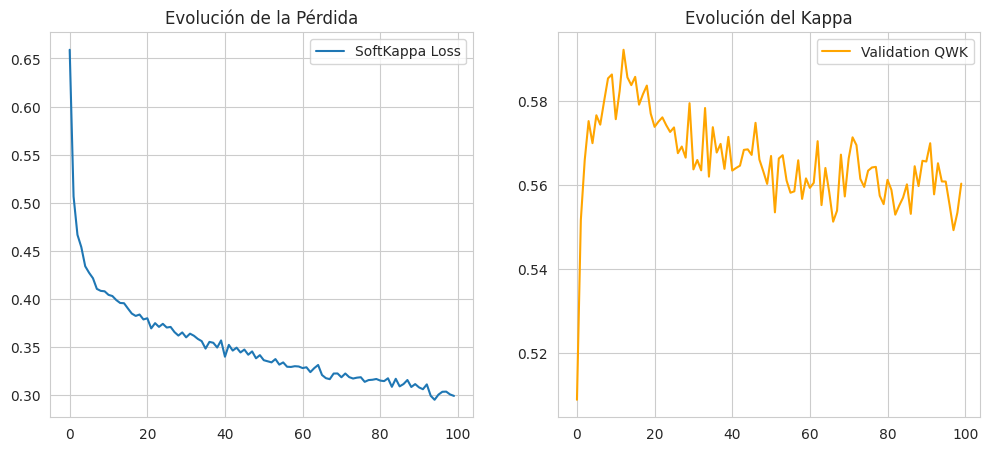

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import cohen_kappa_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- DEFINICIÓN DE LA SOFT KAPPA LOSS (La Magia) ---
class SoftKappaLoss(nn.Module):
    def __init__(self, num_classes=5, device='cuda'):
        super(SoftKappaLoss, self).__init__()
        self.num_classes = num_classes
        self.device = device
        
    def forward(self, pred, target):
        # pred: Logits directos del modelo (Batch, 5) -> Aplicamos Softmax
        pred = torch.softmax(pred, dim=1)
        
        # target: Índices de clases reales (Batch) -> Convertimos a One-Hot
        target_one_hot = torch.zeros_like(pred)
        target_one_hot.scatter_(1, target.view(-1, 1), 1)
        
        # Pesos cuadráticos (Matriz de distancias)
        r = torch.arange(self.num_classes, dtype=torch.float32, device=self.device)
        col_mat = r.unsqueeze(0)
        row_mat = r.unsqueeze(1)
        weight_mat = (col_mat - row_mat) ** 2 # Distancia cuadrática
        
        # Matriz de Confusión Suave (Batch-wise)
        # O = Observed (Predicción x Realidad)
        O = torch.matmul(pred.t(), target_one_hot)
        
        # E = Expected (Distribución marginal)
        pred_hist = pred.sum(dim=0)
        target_hist = target_one_hot.sum(dim=0)
        E = torch.outer(pred_hist, target_hist)
        
        # Normalización
        num_ratings = pred.shape[0]
        O = O / num_ratings
        E = E / (num_ratings ** 2)
        
        # Cálculo final del Kappa
        numerator = (weight_mat * O).sum()
        denominator = (weight_mat * E).sum()
        
        # Loss = 1 - Kappa (porque queremos minimizar la pérdida)
        # Añadimos un pequeño epsilon para estabilidad numérica
        loss = numerator / (denominator + 1e-7)
        
        return loss

# --- CONFIGURACIÓN DEL ENTRENAMIENTO ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instanciamos el modelo de nuevo para reiniciar pesos
model = WideAndDeepModel(len(tab_cols), len(img_cols)).to(device)

# USAMOS LA NUEVA LOSS
criterion = SoftKappaLoss(num_classes=5, device=device)

# Optimizador (A veces AdamW va mejor para generalizar)
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

print(f"🧠 Iniciando entrenamiento Wide & Deep con SoftKappaLoss en {device}...")

epochs = 100
best_qwk = -1.0
history_loss = []
history_qwk = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    for x_t, x_i, labels in train_loader:
        x_t, x_i, labels = x_t.to(device), x_i.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(x_t, x_i)
        
        # La Loss ya se encarga del Softmax internamente
        loss = criterion(outputs, labels) 
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    # Evaluación en Test
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x_t, x_i, labels in test_loader:
            x_t, x_i, labels = x_t.to(device), x_i.to(device), labels.to(device)
            outputs = model(x_t, x_i)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
    avg_loss = total_loss/len(train_loader)
    
    history_loss.append(avg_loss)
    history_qwk.append(qwk)
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Loss (1-Kappa): {avg_loss:.4f} | Val QWK: {qwk:.4f}")

# --- RESULTADOS FINALES ---
print("\n" + "="*50)
print(f"🏆 RESULTADO WIDE & DEEP (Optimizado por QWK)")
print("="*50)
print(f"Final Quadratic Weighted Kappa: {qwk:.5f}")
print("-" * 50)
print(classification_report(all_labels, all_preds))

# --- VISUALIZACIÓN MATRIZ DE CONFUSIÓN ---
plt.figure(figsize=(10, 8))
cm_nn = confusion_matrix(all_labels, all_preds)

sns.heatmap(cm_nn, annot=True, fmt='d', cmap='RdPu', cbar=False,
            xticklabels=[0, 1, 2, 3, 4],
            yticklabels=[0, 1, 2, 3, 4])

plt.title('Matriz de Confusión - Wide & Deep (SoftKappa Loss)', fontsize=16)
plt.xlabel('Predicción del Modelo', fontsize=12)
plt.ylabel('Clase Real', fontsize=12)
plt.show()

# Gráfico de Evolución
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_loss, label='SoftKappa Loss')
plt.title('Evolución de la Pérdida')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_qwk, color='orange', label='Validation QWK')
plt.title('Evolución del Kappa')
plt.legend()
plt.show()

# Comparativa Final de Arquitecturas

En esta sección consolidamos los resultados obtenidos por las cuatro estrategias de modelado híbrido implementadas.

**Modelos Evaluados:**
1.  **XGBoost Multiclass:** Clasificación estándar (Baseline).
2.  **XGBoost Regressor + OptimizedRounder:** Enfoque de regresión ajustando umbrales de decisión.
3.  **Frank & Hall (Ordinal LGBM):** Descomposición en clasificadores binarios secuenciales.
4.  **Wide & Deep (SoftKappa Loss):** Red neuronal con función de pérdida personalizada.

**Métrica de Decisión:**
La métrica principal para seleccionar el modelo ganador es el **Quadratic Weighted Kappa (QWK)**, tal como establecen las reglas de la competición y la naturaleza del problema.

# 7. Comparativa Final de Arquitecturas

En esta sección consolidamos los resultados obtenidos por todas las estrategias de modelado híbrido implementadas. Evaluamos el desempeño comparando modelos de clasificación multiclase, descomposición ordinal, redes neuronales profundas y regresión optimizada.

**Métrica de Decisión:**
La métrica principal es el **Quadratic Weighted Kappa (QWK)**. A diferencia del Accuracy, el QWK penaliza los errores de forma cuadrática según la distancia entre la clase predicha y la real, lo que resulta fundamental en un problema ordinal como la velocidad de adopción de mascotas.

**Modelos Evaluados:**
1. **XGBoost Multiclass:** Clasificación estándar sobre el dataset fusionado.
2. **Frank & Hall (Ordinal LGBM):** Clasificadores binarios secuenciales para capturar la jerarquía de las clases.
3. **Wide & Deep (CE Baseline):** Red neuronal con arquitectura híbrida y pérdida de entropía cruzada.
4. **Wide & Deep (Reg + Opt):** Red neuronal entrenada como regresión con optimización de umbrales.
5. **Wide & Deep (SoftKappa Loss):** Red neuronal optimizada directamente mediante una aproximación diferenciable de la métrica Kappa.
6. **XGBoost Regressor (+OptRound):** Modelo de regresión con optimización dinámica de puntos de corte.

Primeramente, como baseline, vamos a obtener una comparativa de los distintos modelos obteniendo los datos de las imágenes con la Efficient-Net.

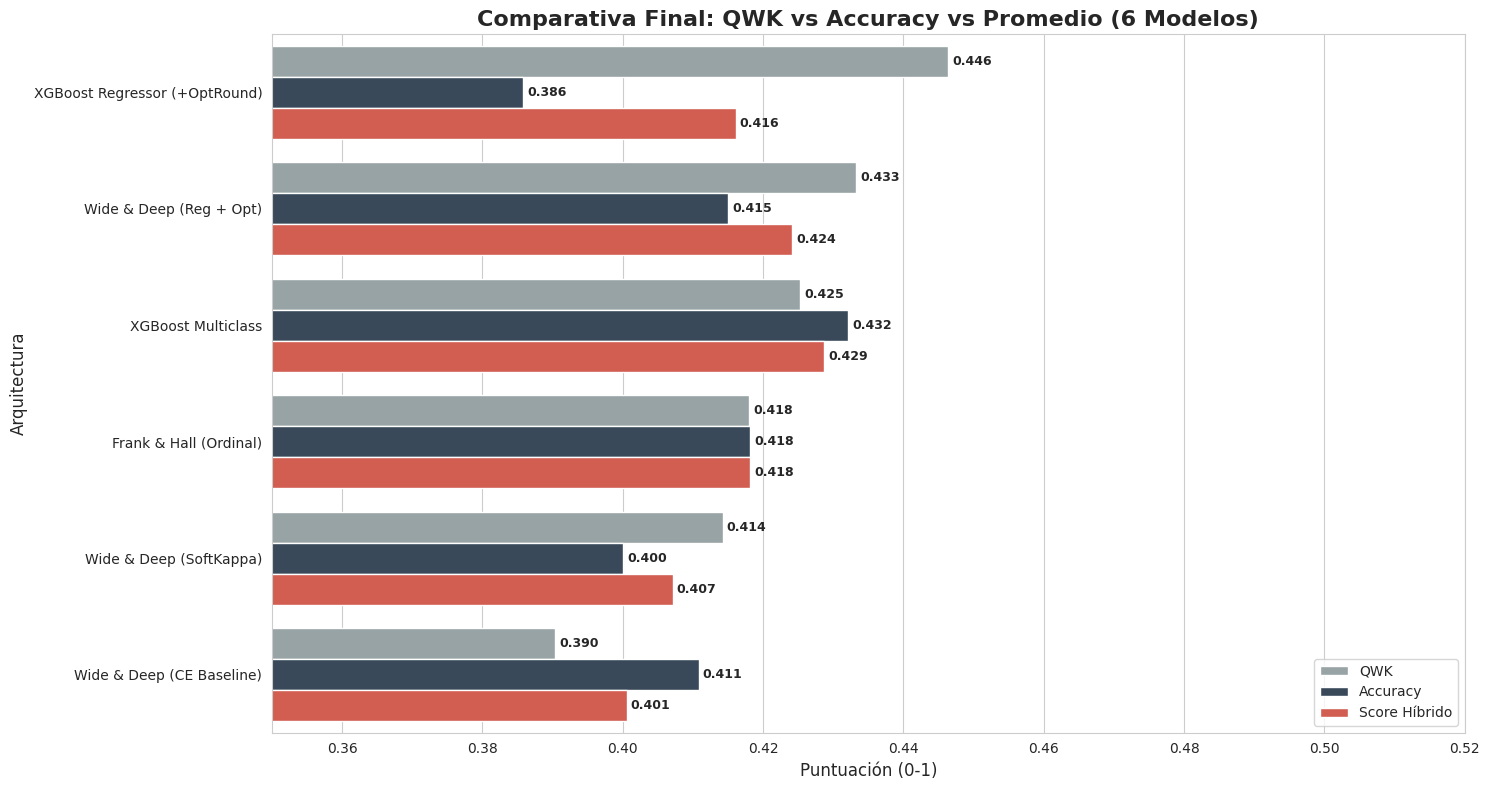


📋 TABLA DEFINITIVA DE RESULTADOS:


,Modelo,QWK,Accuracy,Score Híbrido
5,XGBoost Regressor (+OptRound),0.44638,0.38580,0.416090
3,Wide & Deep (Reg + Opt),0.43327,0.41500,0.424135
0,XGBoost Multiclass,0.42523,0.43214,0.428685
1,Frank & Hall (Ordinal),0.41805,0.41814,0.418095
4,Wide & Deep (SoftKappa),0.41421,0.40000,0.407105
2,Wide & Deep (CE Baseline),0.39030,0.41080,0.400550


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

# 1. RECOPILACIÓN DE RESULTADOS (6 MODELOS)
# Usamos los valores exactos que han ido saliendo en tus celdas
results_data = {
    'Modelo': [
        'XGBoost Multiclass', 
        'Frank & Hall (Ordinal)', 
        'Wide & Deep (CE Baseline)',
        'Wide & Deep (Reg + Opt)',
        'Wide & Deep (SoftKappa)', 
        'XGBoost Regressor (+OptRound)'
    ],
    'QWK': [
        0.42523, # XGBoost Multimodal
        0.41805, # Frank & Hall
        0.39030, # W&D Cross Entropy
        0.43327, # W&D Regresión
        0.41421, # W&D SoftKappa
        0.44638  # XGBoost Regressor Ganador
    ],
    'Accuracy': [
        0.43214,
        0.41814,
        0.41080,
        0.41500, # W&D Reg
        0.40000, # W&D SoftKappa
        0.38580  # XGBoost Reg
    ]
}

df_results = pd.DataFrame(results_data)
df_results['Score Híbrido'] = (df_results['QWK'] + df_results['Accuracy']) / 2
df_results = df_results.sort_values(by='QWK', ascending=False)

# 2. Visualización Comparativa Triple
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

df_melted = df_results.melt(id_vars='Modelo', value_vars=['QWK', 'Accuracy', 'Score Híbrido'], 
                            var_name='Métrica', value_name='Valor')

ax = sns.barplot(
    x='Valor', 
    y='Modelo', 
    hue='Métrica',
    data=df_melted,
    palette={'QWK': '#95a5a6', 'Accuracy': '#34495e', 'Score Híbrido': '#e74c3c'}
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=9, fontweight='bold')

plt.title('Comparativa Final: QWK vs Accuracy vs Promedio (6 Modelos)', fontsize=16, fontweight='bold')
plt.xlabel('Puntuación (0-1)', fontsize=12)
plt.ylabel('Arquitectura', fontsize=12)
plt.xlim(0.35, 0.52)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 3. Tabla Resumen
print("\n📋 TABLA DEFINITIVA DE RESULTADOS:")
display(df_results)

A continuación, vamos a observar el comportamiento de los distintos modelos con sus matrices de confusión.

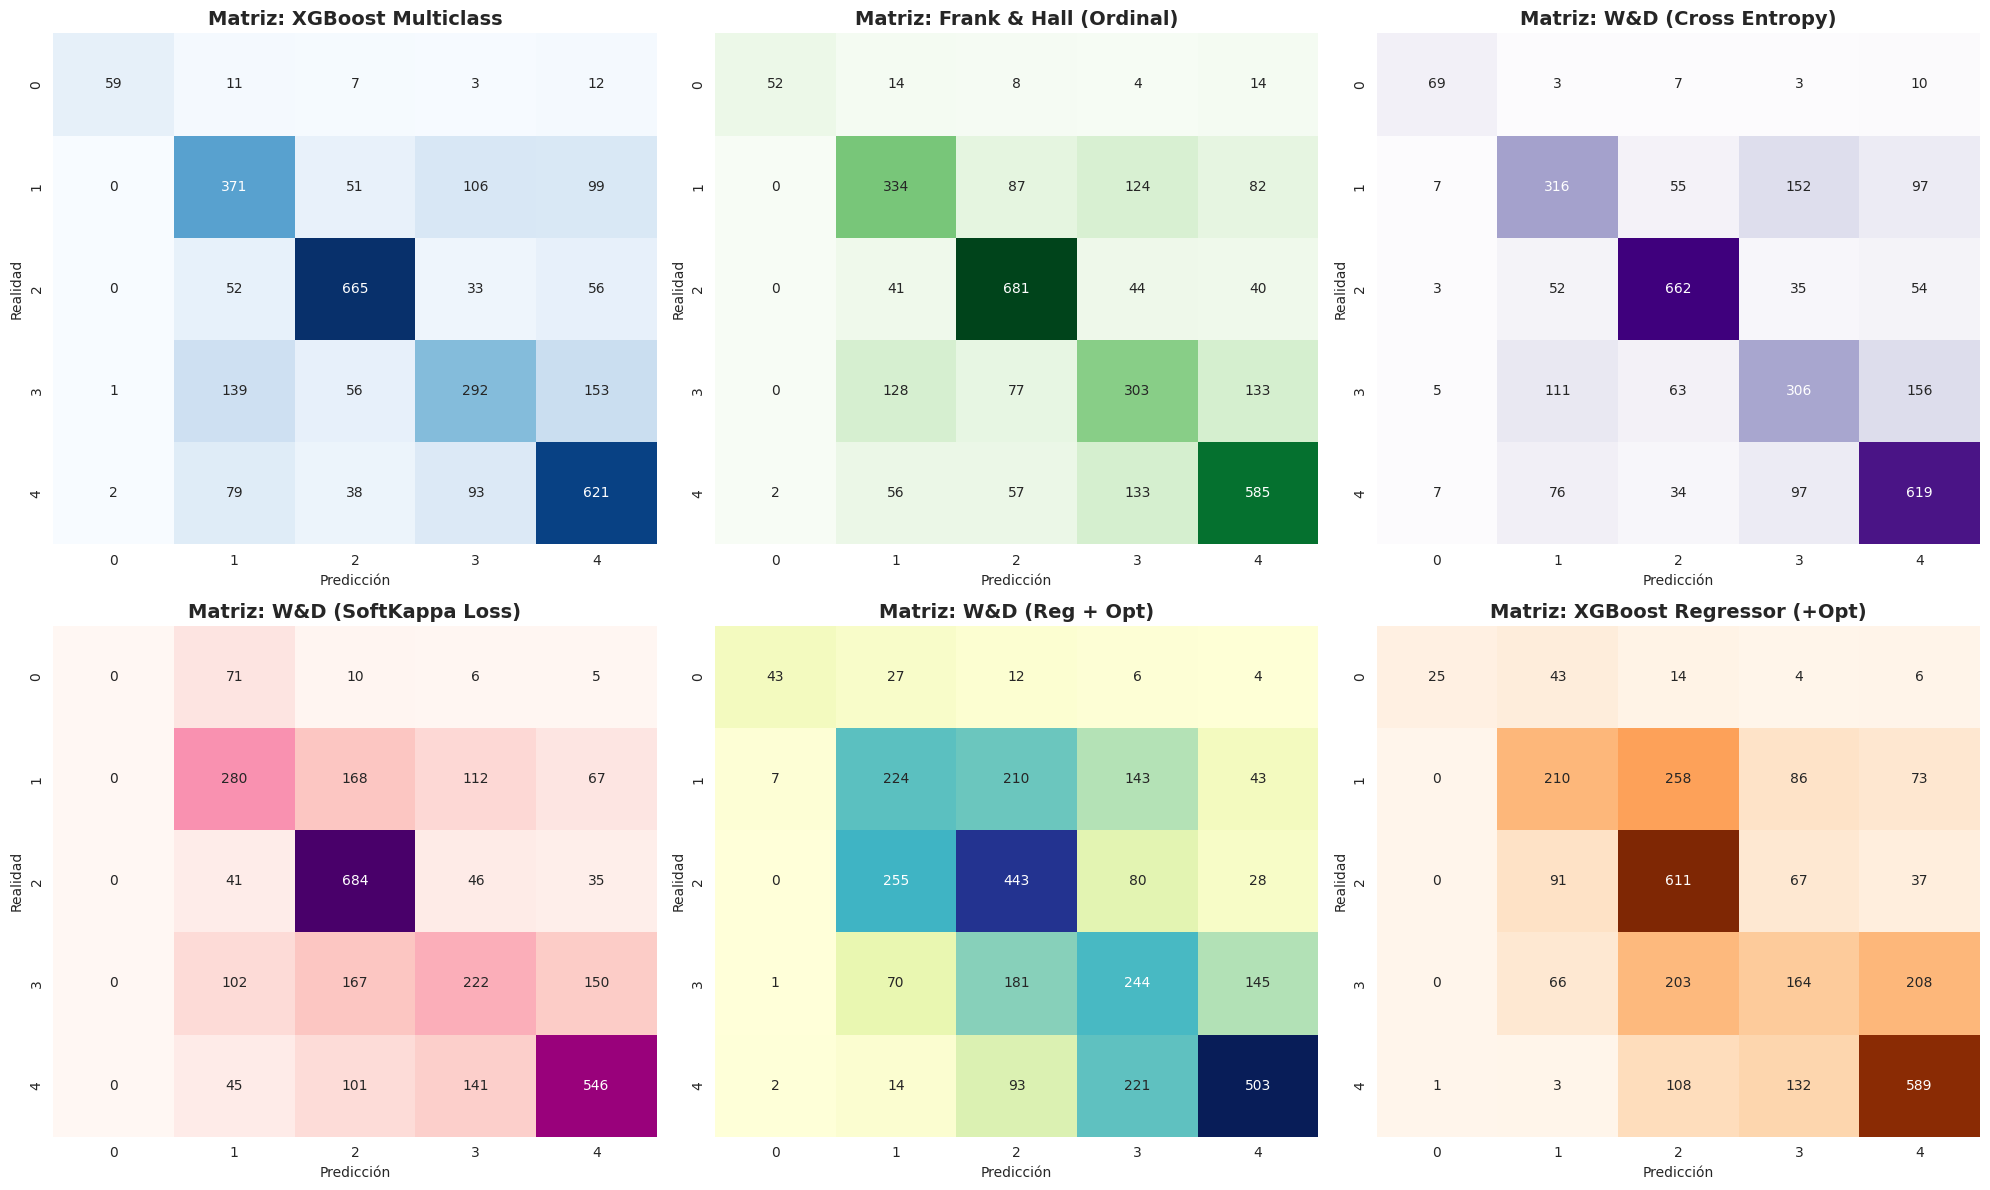

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- 1. DEFINICIÓN DE LOS DATOS DE LAS MATRICES ---
# Extraemos las matrices basadas en las predicciones guardadas en el notebook
models_cm = {
    'XGBoost Multiclass': (y_test, y_pred, 'Blues'),
    'Frank & Hall (Ordinal)': (y_test, y_pred_fh, 'Greens'),
    'W&D (Cross Entropy)': (all_labels_ce, all_preds_ce, 'Purples'),
    'W&D (SoftKappa Loss)': (all_labels, all_preds, 'RdPu'),
    'W&D (Reg + Opt)': (true_labels, final_preds, 'YlGnBu'),
    'XGBoost Regressor (+Opt)': (y_test, y_pred_final, 'Oranges')
}

# --- 2. CONFIGURACIÓN DE LA FIGURA ---
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, (name, (y_true, y_p, cmap)) in enumerate(models_cm.items()):
    cm = confusion_matrix(y_true, y_p)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False, ax=axes[i],
                xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
    
    axes[i].set_title(f'Matriz: {name}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Predicción', fontsize=10)
    axes[i].set_ylabel('Realidad', fontsize=10)

plt.tight_layout()
plt.show()

Finalmente hacemos una comparativa de todos los modelos comparando su rendimiento obteniendo los datos con la Efficient-Net y por otro lado por la ResNet preentrenada.

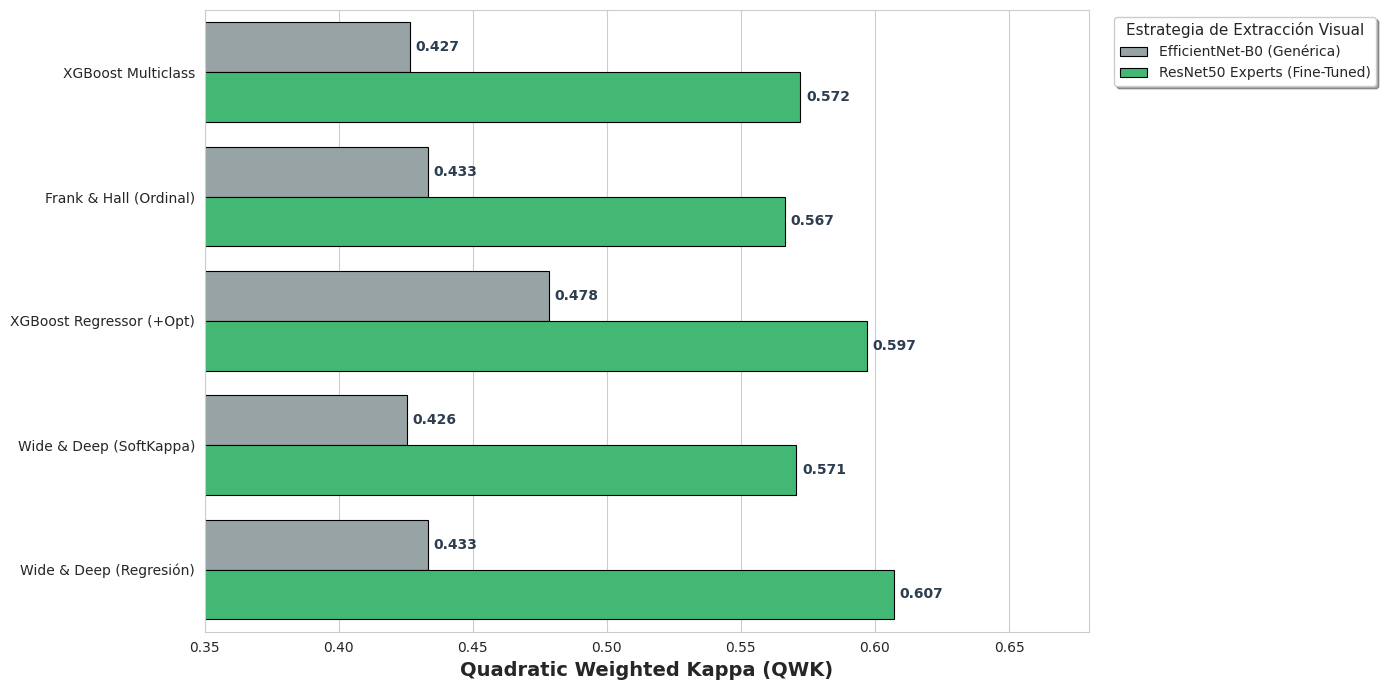


📊 ANÁLISIS DE MEJORA POR MODELO:
---------------------------------------------------------------------------
🔹 XGBoost Multiclass        | 0.4266 -> 0.5722 | Mejora: +34.13%
🔹 Frank & Hall (Ordinal)    | 0.4333 -> 0.5665 | Mejora: +30.74%
🔹 XGBoost Regressor (+Opt)  | 0.4784 -> 0.5969 | Mejora: +24.77%
🔹 Wide & Deep (SoftKappa)   | 0.4256 -> 0.5707 | Mejora: +34.09%
🔹 Wide & Deep (Regresión)   | 0.4332 -> 0.6072 | Mejora: +40.17%
---------------------------------------------------------------------------
🚀 MEJORA MEDIA DEL SISTEMA GRACIAS A LOS EXPERTOS: +32.78%


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# 8. COMPARATIVA GLOBAL: EFFICIENTNET VS. RESNET EXPERTS (VISUALIZACIÓN FINAL)
# =============================================================================

# Datos recopilados (Valores reales de tus experimentos)
data_global = {
    'Modelo': [
        'XGBoost Multiclass', 'XGBoost Multiclass',
        'Frank & Hall (Ordinal)', 'Frank & Hall (Ordinal)',
        'XGBoost Regressor (+Opt)', 'XGBoost Regressor (+Opt)',
        'Wide & Deep (SoftKappa)', 'Wide & Deep (SoftKappa)',
        'Wide & Deep (Regresión)', 'Wide & Deep (Regresión)'
    ],
    'Extractor Visual': [
        'EfficientNet-B0 (Genérica)', 'ResNet50 Experts (Fine-Tuned)',
        'EfficientNet-B0 (Genérica)', 'ResNet50 Experts (Fine-Tuned)',
        'EfficientNet-B0 (Genérica)', 'ResNet50 Experts (Fine-Tuned)',
        'EfficientNet-B0 (Genérica)', 'ResNet50 Experts (Fine-Tuned)',
        'EfficientNet-B0 (Genérica)', 'ResNet50 Experts (Fine-Tuned)'
    ],
    'QWK Score': [
        0.4266, 0.5722,  # XGBoost Multi
        0.4333, 0.5665,  # Frank & Hall
        0.4784, 0.5969,  # XGBoost Regressor
        0.4256, 0.5707,  # W&D SoftKappa
        0.4332, 0.6072   # W&D Regresión
    ]
}

df_global = pd.DataFrame(data_global)

# Configuración del gráfico (Más ancho para acomodar la leyenda fuera)
plt.figure(figsize=(14, 7)) 
sns.set_style("whitegrid")

# Paleta de colores profesional
palette = {'EfficientNet-B0 (Genérica)': '#95a5a6', 'ResNet50 Experts (Fine-Tuned)': '#2ecc71'}

ax = sns.barplot(
    x='QWK Score', 
    y='Modelo', 
    hue='Extractor Visual',
    data=df_global,
    palette=palette,
    edgecolor='black',
    linewidth=0.8
)

# Añadir valores numéricos en las barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=4, fontsize=10, fontweight='bold', color='#2c3e50')

# Títulos y Ejes
plt.xlabel('Quadratic Weighted Kappa (QWK)', fontsize=14, fontweight='bold')
plt.ylabel('', fontsize=12)

# --- CORRECCIÓN DE LA LEYENDA ---
# La sacamos fuera del gráfico (a la derecha) para que no tape las barras largas
plt.legend(
    title='Estrategia de Extracción Visual',
    title_fontsize=11,
    bbox_to_anchor=(1.02, 1), # Coordenada (X, Y) relativa. 1.02 lo saca fuera a la derecha.
    loc='upper left',         # Anclamos la esquina superior izquierda de la leyenda ahí.
    fontsize=10,
    frameon=True,
    shadow=True
)

# Ajuste de límites (Zoom en la zona interesante)
plt.xlim(0.35, 0.68) 

# Tight layout ajusta los márgenes automáticamente para que no se corte la leyenda externa
plt.tight_layout()
plt.show()

# --- CÁLCULO DE MEJORA ---
print("\n📊 ANÁLISIS DE MEJORA POR MODELO:")
print("-" * 75)
models = df_global['Modelo'].unique()
total_imp = 0
for m in models:
    score_eff = df_global[(df_global['Modelo'] == m) & (df_global['Extractor Visual'].str.contains('Efficient'))]['QWK Score'].values[0]
    score_res = df_global[(df_global['Modelo'] == m) & (df_global['Extractor Visual'].str.contains('ResNet'))]['QWK Score'].values[0]
    imp = ((score_res - score_eff) / score_eff) * 100
    total_imp += imp
    print(f"🔹 {m:<25} | {score_eff:.4f} -> {score_res:.4f} | Mejora: +{imp:.2f}%")

avg_imp = total_imp / len(models)
print("-" * 75)
print(f"🚀 MEJORA MEDIA DEL SISTEMA GRACIAS A LOS EXPERTOS: +{avg_imp:.2f}%")
print("=" * 75)

# Discusión y Conclusión

En este cuaderno se ha explorado distintas metodologías del problema de clasificación ordinal de la base de datos PetFinder. En concreto se han probado dos formas de obtener resultados usando tanto datos tabulares como imágenes a través de la fusión temprana y una estructura end to end llamada Wide and Deep.

Además se ha comparado la necesidad de un fine tunning de una red para la estracción de características de las imagenes frente a una red preentrenada conocida por su gran rendimiento (Efficient-Net) obteniendo una mejora de más del 30% en cada modelo comparando la métrica Quadratic weigted kappa.

Finalmente, podemos ver cómo el mejor modelo ha sido Wide and Deep con un QWK de 0.607 seguido de cerca por el XGBoost con un qwk de 0.597, en ambos aplicando regresión y optimizando los cortes entre clases. Esto nos da a entender que ambos modelos están sacando el máximo potencial al dataset e incluso comparando sus matrices de confusión, vemos que son similares y cometen errores similares.

En conclusión hemos podido demostrar que el uso de datos tabulares y de imágenes supera a los modelos tradicionales de clasificación ordinal como el XGBoost o los de imágenes con redes preentrenadas. Además hemos descubierto distintas maneras de enfrentar un problema de clasificación ordinal y todos los inconvenientes que tienen cada una de las metodologías empleadas.